## Imports

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Khaled\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khaled\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import time
import datetime

In [3]:
# Beep when notebook stops running code
import winsound
def beep(reps=1, duration=500, freq=440, sleep=1):
    for _ in range(reps - 1):
        winsound.Beep(freq, duration)
        time.sleep(sleep)
    winsound.Beep(freq, duration)

## Data

Load the cleaned reviews:

In [4]:
%%time
data = "dataset/preprocessed_dataset.csv"
df = pd.read_csv(data)
df = df[df.reviewTextPreprocessed.notna()]
df.head()

Wall time: 9.45 s


In [5]:
df.shape

(3941926, 3)

See proportion of positive ($>3$) and critical ($\leq 3$) reviews:

In [6]:
df["positive"] = df.overall > 3

In [7]:
df.groupby("positive").size()

positive
False     625479
True     3316447
dtype: int64

In [8]:
df.groupby("positive").size()/(df.shape[0])

positive
False    0.158673
True     0.841327
dtype: float64

The class to predict is highly unbalanced. We can sample in order to have a balanced class:

In [9]:
sample_size = 500000 # needs to be less than the number of observations in the minority class
sample_df = df.groupby('positive').apply(lambda x: x.sample(sample_size))

In [10]:
sample_df = sample_df.reset_index(level=0, drop=True) # remove outer level of multiindex

In [11]:
sample_df.groupby("positive").size()

positive
False    500000
True     500000
dtype: int64

#### Choice: Unbalanced or Balanced Classes

Definition of unbalanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on the reviews from the Amazon dataset.

In [12]:
# X = df.reviewTextPreprocessed.values
# y = df.positive.values

Definition of balanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on tweets (which might not be unbalanced in the same way as this dataset).

In [13]:
X = sample_df.reviewTextPreprocessed.values
y = sample_df.positive.values

## Order of operations from now on:

First of all, we define a list of stopwords.

The next step is the preprocessing needed to obtain a suitable representation of the reviews, which are:

- Tokenization
- Spelling correction
- Stop words removal
- Stemming

After these operations, the reviews are going to be passed to a vectorizer in order to obtain the final representation for the classifiers.

Stemming can be achieved using two different libraries: NLTK and PyStemmer. PyStemmer is faster, but needs Visual C++ Build Tools installed. Please choose the relevant code you prefer to run.

#### Rough execution times:

(Execution times might be different from the following, I ran the notebook again afterwards)

#### NLTK

- Tokenization, 3min 15s
- Spell check and correction, 14min 11s (`proprocessor` parameter)
- Stop words removal, 1min 6s (`stop_words` parameter)
- Stemming, 7min 10s (Porter) 5min 56s (Lancaster)
- Vectorization, 58.8 s (Porter), 56.6 s(Lancaster)

#### PyStemmer

Class that performs

- Tokenization
- Spell check and correction (parameter `preprocessor`)
- Stop words removal (parameter `stop_words`)
- Stemming (with `pystemmer`)
- Vectorization

8min 49s

### Definition of the list of Stop-words

In [14]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

The list of stop words needs to be preprocessed in the same way as the reviews. We define the  dictionaries needed for the preprocessing, as in the previous notebook:

In [15]:
emoticon_repl = {
    # positive emoticons
    r":-?d+": " good ", r":[- ]?\)+": " good ", r";-?\)+": " good ", # ;). ;)). ;-), ecc.
    r"\(+-?:": " good ", r"=\)+" : " good ", r"\b<3\b" : " good ",    
    # negative emoticons
    r"[\s\r\t\n]+:/+": " bad ", r":\\+": " bad ", r"[\s\r\t\n]+\)-?:": " bad ",  # ):, )):, )-:, ecc.
    r":-?\(+": " bad ", r"[\s\t\r\n]+d+-?:": " bad "
}

contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not", r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not", r"ain\'": "is not",
    # casi generali
    r"n\'t": " not", r"\'t": " not", r"n\'": " not", r"\'s": " is", r"\'ve": " have", 
    r"\'re": " are", 
    r"\'ll": " will", r"\'d": " would",
}

with open('dataset/slang_subset_manual.json', 'r') as fid:
    slang_repl = json.load(fid)

Same preprocessing function as in the previous notebook:

In [16]:
def preprocess(sent, translate_slang = True):
    
    sent = sent.lower()
    sent = re.sub(r'^<div id="video.*>&nbsp;', '', sent) # Video-review part
    sent = re.sub('https?://[A-Za-z0-9./]+', '', sent) # URLs
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    if translate_slang:
        for k in slang_repl:
            sent = re.sub(r"\b"+re.escape(k)+r"\b", slang_repl[k], sent)
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    sent = re.sub('[/]+', ' ', sent) # word1/word2 to word1 word2
    sent = re.sub('[^A-Za-z0-9-_ ]+', '', sent)
    sent = re.sub('\b\d+\b', '', sent)
    
    return sent

In [17]:
prep_stopws = [preprocess(el) for el in stopws]

Words containing "not" are important for our tasks

In [18]:
np.array(prep_stopws[-36:])

array(['ain', 'aren', 'are not', 'couldn', 'could not', 'didn', 'did not',
       'doesn', 'does not', 'hadn', 'had not', 'hasn', 'has not', 'haven',
       'have not', 'isn', 'is not', 'ma', 'mightn', 'might not', 'mustn',
       'must not', 'needn', 'need not', 'shan', 'shall not', 'shouldn',
       'should not', 'wasn', 'was not', 'weren', 'were not', 'won',
       'will not', 'wouldn', 'would not'], dtype='<U10')

In [19]:
prep_stopws = prep_stopws[:-36]

Other words to remove from the stop words:

In [20]:
for word in ["not", "very", "don", "do not"]:
    prep_stopws.remove(word)

In [21]:
prep_stopws.extend(["youse", "would"]) # needed for consistency with spell checker

## Tokenization/Spell Correction/StopWordsRemoval/Stemming

### NLTK

In [22]:
from nltk.tokenize import word_tokenize
def tokenize_reviews(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    return tokenized_reviews

In [23]:
%%time
X_tokenized = tokenize_reviews(X)

Wall time: 2min 59s


Spelling correction:

In [24]:
def fix_spelling_mistakes(reviews, dist=1):
    spell = SpellChecker(distance=dist)
    reviews_with_right_spell = []
    for review in reviews:
        corrected_review = [spell.correction(word) for word in review]
        reviews_with_right_spell.append(corrected_review)
    return reviews_with_right_spell

In [25]:
%%time
X_spellchecked = fix_spelling_mistakes(X_tokenized)

Wall time: 15min 12s


Stop words removal:

In [26]:
%%time
X_noStopWords = []
for review in X_spellchecked:
        cleaned_review = [word for word in review if word not in prep_stopws]
        X_noStopWords.append(cleaned_review)

Wall time: 44.6 s


In [27]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [28]:
def stem_reviews(reviews, stemmer_name="Porter"):
    if stemmer_name == "Porter":
        stemmer = PorterStemmer()
    elif stemmer_name == "Lancaster":
        stemmer = LancasterStemmer()
    else:
        raise SystemError
    stemmed_reviews = []
    for review in reviews:
        stemmed_reviews.append([stemmer.stem(word) for word in review])
    return stemmed_reviews

In [29]:
%%time
X_Porter = stem_reviews(X_noStopWords, stemmer_name = "Porter")

Wall time: 5min 56s


In [30]:
%%time
X_Lancaster = stem_reviews(X_noStopWords, stemmer_name = "Lancaster")

Wall time: 4min 59s


### PyStemmer (needs Visual C++ installed)

Definition of the class StemmedTdidfVectorized.

- `sklearn`'s `TfidfVectorizer` takes care of tokenization, stop-word removal, vectorization
- `pystemmer` takes care of stemming.

In [31]:
import Stemmer
english_stemmer = Stemmer.Stemmer('en')

In [32]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

## Train-test split

In [33]:
from sklearn.model_selection import train_test_split

#### NLTK

Here we are train/test splitting the set of reviews that is already tokenized and stemmed, to be passed to TfidfVectorizer for representation.

In [34]:
X_train_Porter, X_test_Porter, y_train, y_test = train_test_split(X_Porter, y,
                                                                  test_size=0.33, random_state=42)
X_train_Lancaster, X_test_Lancaster, y_train, y_test = train_test_split(X_Lancaster, y,
                                                                        test_size=0.33, random_state=42)

#### Pystemmer

Here we are train/test splitting the preprocessed set of reviews to be passed to `StemmedTfidfVectorizer` for tokenization+stemming+representation.

In [35]:
X_train_pystemmer, X_test_pystemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

## Text Representation

#### NLTK

In [36]:
def rebuild_reviews(reviews):
    rebuilt_reviews = []
    for review in reviews:
        rebuilt_reviews.append(" ".join(review))
    return rebuilt_reviews

In [37]:
X_train_Porter = rebuild_reviews(X_train_Porter)
X_test_Porter = rebuild_reviews(X_test_Porter)
X_train_Lancaster = rebuild_reviews(X_train_Lancaster)
X_test_Lancaster = rebuild_reviews(X_test_Lancaster)

In [38]:
%%time
tfidf_vect_Porter = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Porter = tfidf_vect_Porter.fit_transform(X_train_Porter)

Wall time: 40.1 s


In [39]:
%%time
X_test_tfidf_Porter = tfidf_vect_Porter.transform(X_test_Porter)

Wall time: 10.7 s


In [40]:
%%time
tfidf_vect_Lancaster = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Lancaster = tfidf_vect_Lancaster.fit_transform(X_train_Lancaster)

Wall time: 38.8 s


In [41]:
%%time
X_test_tfidf_Lancaster = tfidf_vect_Lancaster.transform(X_test_Lancaster)

Wall time: 10.7 s


In [42]:
dump(tfidf_vect_Porter, 'joblib_data/tfidf_vect_Porter.joblib')
dump(tfidf_vect_Lancaster, 'joblib_data/tfidf_vect_Lancaster.joblib')

['joblib_data/tfidf_vect_Lancaster.joblib']

#### Pystemmer

In [43]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_pystemmer = StemmedTfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_pystemmer = tfidf_vect_pystemmer.fit_transform(X_train_pystemmer)

Wall time: 5min 21s


In [44]:
%%time
X_test_tfidf_pystemmer = tfidf_vect_pystemmer.transform(X_test_pystemmer)

Wall time: 2min 23s


In [45]:
dump(tfidf_vect_pystemmer, 'joblib_data/tfidf_vect_pystemmer.joblib') 

['joblib_data/tfidf_vect_pystemmer.joblib']

In [46]:
beep()

####  No stemming

In [47]:
X_train_nostemmer, X_test_nostemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

In [48]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_nostemmer = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_nostemmer = tfidf_vect_nostemmer.fit_transform(X_train_nostemmer)

Wall time: 4min 17s


In [49]:
%%time
X_test_tfidf_nostemmer = tfidf_vect_nostemmer.transform(X_test_nostemmer)

Wall time: 1min 52s


In [50]:
dump(tfidf_vect_nostemmer, 'joblib_data/tfidf_vect_nostemmer.joblib') 

['joblib_data/tfidf_vect_nostemmer.joblib']

In [51]:
beep()

# Classification

## NB Classifier

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

Accessory functions:

In [53]:
def print_top_features(vectorizer, clf, n = 10):
    fnames = vectorizer.get_feature_names()
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(fnames[j] for j in top_pos))

In [55]:
def score_model(clf, X_train, X_test, y_train, y_test, probabilities = True):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy
    
    predictions = clf.predict(X_test)

    prec = precision_score(y_test, predictions) # Precision
    rec = recall_score(y_test, predictions) # Recall
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, 2) # F2
    cm = confusion_matrix(y_test, predictions)
    if probabilities:
        proba = clf.predict_proba(X_test)

        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

        auc_score = auc(recall, precision)

        scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                          "Test Recall", "F1", "F2", "P/R AUC"]

        scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

        print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

        print(classification_report(y_test, predictions, digits=5))

        plt.plot(recall, precision, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
        plt.legend(loc="lower left")
        plt.show()
    else:
        scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                          "Test Recall", "F1", "F2"]

        scores = [train_score, test_score, prec, rec, f1, f2]

        print(("{:20s} {:.5f}\n"*6)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

        print(classification_report(y_test, predictions, digits=5))

###  No Stemmer

In [56]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_nostemmer, y_train)

Wall time: 219 ms


In [57]:
print_top_features(tfidf_vect_nostemmer, clf, 50)

Most discriminative features:
 great, good, love, works, product, very, not, perfect, excellent, nice, like, price, well, fit, works great, easy, case, one, quality, great product, phone, use, best, game, very good, really, worked, awesome, buy, fits, time, perfectly, get, work, install, much, little, used, delicious, looks, good product, taste, better, described, recommend, bought, fast, expected, ok, thanks


In [58]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer)

Wall time: 46.9 ms


Train Accuracy       0.85601
Test Accuracy        0.84922
Test Precision       0.86423
Test Recall          0.82880
F1                   0.84614
F2                   0.83565
P/R AUC              0.92169
             precision    recall  f1-score   support

      False    0.83539   0.86967   0.85219    164923
       True    0.86423   0.82880   0.84614    165077

avg / total    0.84982   0.84922   0.84916    330000



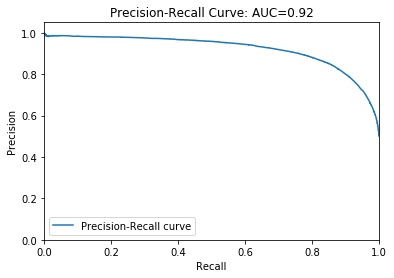

Wall time: 1.06 s


In [59]:
%%time
score_model(clf, X_train_tfidf_nostemmer, X_test_tfidf_nostemmer, y_train, y_test)

In [60]:
beep()

In [61]:
dump(clf, 'joblib_data/clf_nb_nostemmer.joblib') 

['joblib_data/clf_nb_nostemmer.joblib']

### NLTK

#### Porter

In [62]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Porter, y_train)

Wall time: 271 ms


In [63]:
print_top_features(tfidf_vect_Porter, clf, 50)

Most discriminative features:
 great, good, work, love, product, veri, not, fit, perfect, work great, excel, nice, use, like, price, well, case, phone, one, easi, look, great product, qualiti, game, instal, thank, tast, best, need, veri good, buy, time, get, awesom, realli, make, recommend, perfectli, expect, much, littl, good product, delici, describ, light, better, replac, fast, ok, bought


In [64]:
%%time
predictions = clf.predict(X_test_tfidf_Porter)

Wall time: 78.1 ms


Train Accuracy       0.85311
Test Accuracy        0.84598
Test Precision       0.86120
Test Recall          0.82508
F1                   0.84275
F2                   0.83206
P/R AUC              0.92011
             precision    recall  f1-score   support

      False    0.83197   0.86690   0.84907    164923
       True    0.86120   0.82508   0.84275    165077

avg / total    0.84659   0.84598   0.84591    330000



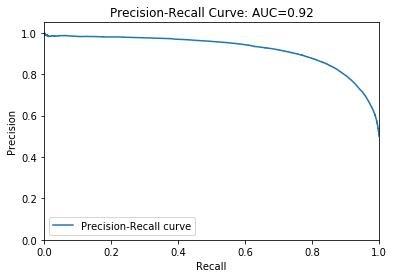

Wall time: 1e+03 ms


In [65]:
%%time
score_model(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)

In [66]:
dump(clf, 'joblib_data/clf_nb_porter.joblib') 

['joblib_data/clf_nb_porter.joblib']

#### Lancaster

In [67]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Lancaster, y_train)

Wall time: 203 ms


In [68]:
print_top_features(tfidf_vect_Lancaster, clf, 50)

Most discriminative features:
 gre, good, work, lov, perfect, produc, very, not, excel, fit, work gre, us, nic, lik, pric, wel, easy, cas, phon, on, look, gre produc, qual, gam, instal, thank, real, tast, best, nee, buy, very good, tim, get, awesom, protect, mak, recommend, expect, charg, much, light, littl, good produc, delicy, describ, fast, car, bet, ev


In [69]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster)

Wall time: 62.5 ms


Train Accuracy       0.85204
Test Accuracy        0.84457
Test Precision       0.86029
Test Recall          0.82293
F1                   0.84119
F2                   0.83014
P/R AUC              0.91884
             precision    recall  f1-score   support

      False    0.83014   0.86623   0.84781    164923
       True    0.86029   0.82293   0.84119    165077

avg / total    0.84522   0.84457   0.84450    330000



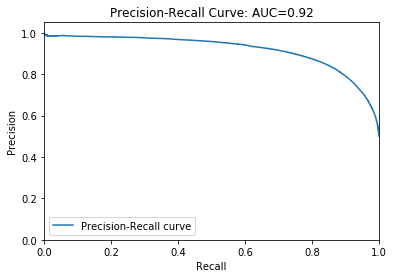

Wall time: 1e+03 ms


In [70]:
%%time
score_model(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)

In [71]:
dump(clf, 'joblib_data/clf_nb_lancaster.joblib') 

['joblib_data/clf_nb_lancaster.joblib']

###  PyStemmer

In [72]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_pystemmer, y_train)

Wall time: 203 ms


In [73]:
print_top_features(tfidf_vect_pystemmer, clf, 50)

Most discriminative features:
 great, good, work, love, perfect, product, veri, not, fit, excel, nice, use, like, price, well, case, works great, one, easi, look, great product, qualiti, phone, game, instal, thank, tast, need, best, buy, time, very good, get, realli, awesom, make, recommend, flavor, expect, much, littl, light, good product, delici, describ, better, replac, fast, bought, ok


In [74]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer)

Wall time: 46.9 ms


Train Accuracy       0.85411
Test Accuracy        0.84679
Test Precision       0.86221
Test Recall          0.82568
F1                   0.84355
F2                   0.83273
P/R AUC              0.92032
             precision    recall  f1-score   support

      False    0.83261   0.86793   0.84990    164923
       True    0.86221   0.82568   0.84355    165077

avg / total    0.84742   0.84679   0.84672    330000



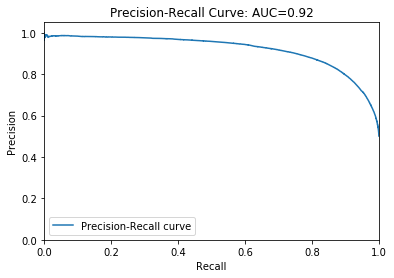

Wall time: 1e+03 ms


In [75]:
%%time
score_model(clf, X_train_tfidf_pystemmer, X_test_tfidf_pystemmer, y_train, y_test)

In [76]:
dump(clf, 'joblib_data/clf_nb_pystemmer.joblib') 

['joblib_data/clf_nb_pystemmer.joblib']

## Random forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

### No stemmer

In [78]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_nostemmer, y_train)

Wall time: 41min 58s


In [79]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer)

Wall time: 6.37 s


Train Accuracy       0.98463
Test Accuracy        0.84545
Test Precision       0.87829
Test Recall          0.80220
F1                   0.83852
F2                   0.81634
P/R AUC              0.92185
             precision    recall  f1-score   support

      False    0.81781   0.88874   0.85180    164923
       True    0.87829   0.80220   0.83852    165077

avg / total    0.84807   0.84545   0.84516    330000



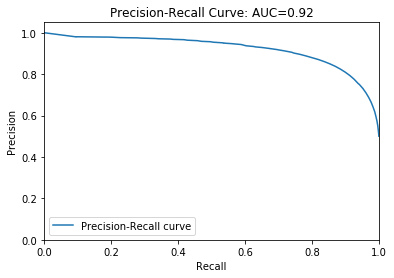

['joblib_data/clf_random_forest_nostemmer.joblib']

In [82]:
score_model(clf, X_train_tfidf_nostemmer, X_test_tfidf_nostemmer, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_nostemmer.joblib")

### Porter

In [83]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Porter, y_train)

Wall time: 42min 27s


In [84]:
%%time
predictions = clf.predict(X_test_tfidf_Porter)

Wall time: 6.09 s


Train Accuracy       0.98455
Test Accuracy        0.84542
Test Precision       0.88152
Test Recall          0.79828
F1                   0.83784
F2                   0.81365
P/R AUC              0.92232
             precision    recall  f1-score   support

      False    0.81553   0.89260   0.85233    164923
       True    0.88152   0.79828   0.83784    165077

avg / total    0.84854   0.84542   0.84508    330000



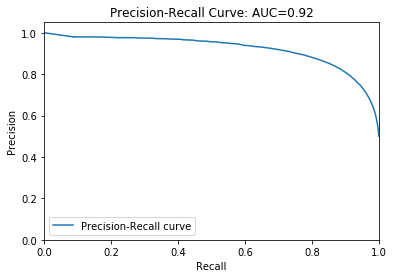

['joblib_data/clf_random_forest_porter.joblib']

In [85]:
score_model(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_porter.joblib")

### Lancaster

In [86]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Lancaster, y_train)

Wall time: 42min 38s


In [87]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster)

Wall time: 5.95 s


Train Accuracy       0.98454
Test Accuracy        0.84452
Test Precision       0.88293
Test Recall          0.79453
F1                   0.83640
F2                   0.81077
P/R AUC              0.92102
             precision    recall  f1-score   support

      False    0.81307   0.89456   0.85187    164923
       True    0.88293   0.79453   0.83640    165077

avg / total    0.84802   0.84452   0.84413    330000



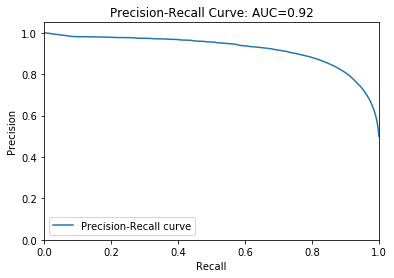

['joblib_data/clf_random_forest_lancaster.joblib']

In [88]:
score_model(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_lancaster.joblib")

### Pystemmer

In [89]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_pystemmer, y_train)

Wall time: 41min 35s


In [90]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer)

Wall time: 6.17 s


Train Accuracy       0.98452
Test Accuracy        0.84536
Test Precision       0.88044
Test Recall          0.79941
F1                   0.83797
F2                   0.81440
P/R AUC              0.92237
             precision    recall  f1-score   support

      False    0.81616   0.89134   0.85210    164923
       True    0.88044   0.79941   0.83797    165077

avg / total    0.84832   0.84536   0.84503    330000



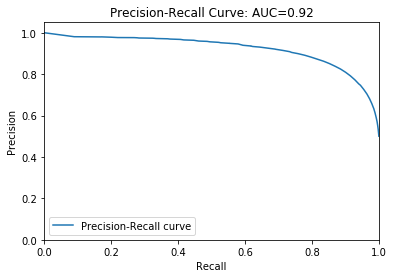

['joblib_data/clf_random_forest_pystemmer.joblib']

In [91]:
score_model(clf, X_train_tfidf_pystemmer, X_test_tfidf_pystemmer, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_pystemmer.joblib")

## TruncatedSVD
The X_train vector has around 50k features: for speeding up the training phase it may be good to use dimensionality reduction methods. Their goal is to preserve "expressive power" while reducing dataset dimensionality.
Because the TFIDF matrix is a sparse one, one of the best method for performing dimensionality reduction is "TruncatedSVD"

### No stemmer

In [92]:
%%time
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_nostemmer_svd = tsvd.fit_transform(X_train_tfidf_nostemmer)
X_test_tfidf_nostemmer_svd = tsvd.transform(X_test_tfidf_nostemmer)

Wall time: 1min 31s


### Porter

In [93]:
%%time
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_Porter_svd = tsvd.fit_transform(X_train_tfidf_Porter)
X_test_tfidf_Porter_svd = tsvd.transform(X_test_tfidf_Porter)

Wall time: 1min 32s


### Lancaster

In [94]:
%%time
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_Lancaster_svd = tsvd.fit_transform(X_train_tfidf_Lancaster)
X_test_tfidf_Lancaster_svd = tsvd.transform(X_test_tfidf_Lancaster)

Wall time: 1min 33s


### Pystemmer

In [95]:
%%time
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_pystemmer_svd = tsvd.fit_transform(X_train_tfidf_pystemmer)
X_test_tfidf_pystemmer_svd = tsvd.transform(X_test_tfidf_pystemmer)

Wall time: 1min 31s


#### Store SVD-transformed dataset

In [96]:
dump(X_train_tfidf_nostemmer_svd, 'joblib_data/X_train_tfidf_nostemmer_svd.joblib')
dump(X_test_tfidf_nostemmer_svd, 'joblib_data/X_test_tfidf_nostemmer_svd.joblib')

['joblib_data/X_test_tfidf_nostemmer_svd.joblib']

In [97]:
dump(X_train_tfidf_Porter_svd, 'joblib_data/X_train_tfidf_Porter_svd.joblib')
dump(X_test_tfidf_Porter_svd, 'joblib_data/X_test_tfidf_Porter_svd.joblib')

['joblib_data/X_test_tfidf_Porter_svd.joblib']

In [98]:
dump(X_train_tfidf_Lancaster_svd, 'joblib_data/X_train_tfidf_Lancaster_svd.joblib')
dump(X_test_tfidf_Lancaster_svd, 'joblib_data/X_test_tfidf_Lancaster_svd.joblib')

['joblib_data/X_test_tfidf_Lancaster_svd.joblib']

In [99]:
dump(X_train_tfidf_pystemmer_svd, 'joblib_data/X_train_tfidf_pystemmer_svd.joblib')
dump(X_test_tfidf_pystemmer_svd, 'joblib_data/X_test_tfidf_pystemmer_svd.joblib')

['joblib_data/X_test_tfidf_pystemmer_svd.joblib']

## Random Forest with TruncatedSVD Dataset

### No stemmer

In [100]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 3min 5s


In [101]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 2.3 s


Train Accuracy       0.98464
Test Accuracy        0.80865
Test Precision       0.82979
Test Recall          0.77681
F1                   0.80243
F2                   0.78686
P/R AUC              0.88689
             precision    recall  f1-score   support

      False    0.79002   0.84051   0.81448    164923
       True    0.82979   0.77681   0.80243    165077

avg / total    0.80992   0.80865   0.80845    330000



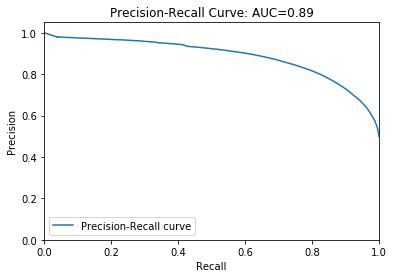

['joblib_data/clf_random_forest_nostemmer_svd.joblib']

In [102]:
score_model(clf, X_train_tfidf_nostemmer_svd, X_test_tfidf_nostemmer_svd, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_nostemmer_svd.joblib")

### Porter

In [103]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 3min 9s


In [104]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 2.25 s


Train Accuracy       0.98458
Test Accuracy        0.80826
Test Precision       0.83311
Test Recall          0.77119
F1                   0.80096
F2                   0.78283
P/R AUC              0.88622
             precision    recall  f1-score   support

      False    0.78684   0.84537   0.81505    164923
       True    0.83311   0.77119   0.80096    165077

avg / total    0.80998   0.80826   0.80800    330000



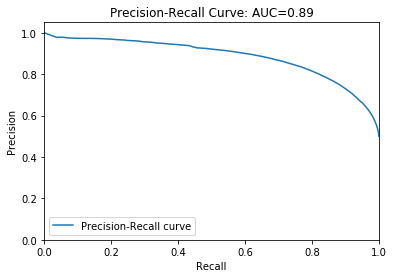

['joblib_data/clf_random_forest_porter_svd.joblib']

In [105]:
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_porter_svd.joblib")

### Lancaster

In [106]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 3min 5s


In [107]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 2.28 s


Train Accuracy       0.98455
Test Accuracy        0.80651
Test Precision       0.83221
Test Recall          0.76806
F1                   0.79885
F2                   0.78009
P/R AUC              0.88510
             precision    recall  f1-score   support

      False    0.78447   0.84500   0.81361    164923
       True    0.83221   0.76806   0.79885    165077

avg / total    0.80835   0.80651   0.80623    330000



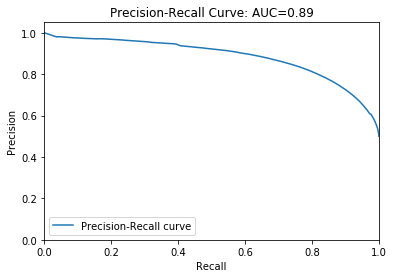

['joblib_data/clf_random_forest_lancaster_svd.joblib']

In [108]:
score_model(clf, X_train_tfidf_Lancaster_svd, X_test_tfidf_Lancaster_svd, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_lancaster_svd.joblib")

### Pystemmer

In [109]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 3min 6s


In [110]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 2.3 s


Train Accuracy       0.98454
Test Accuracy        0.80728
Test Precision       0.83103
Test Recall          0.77163
F1                   0.80023
F2                   0.78282
P/R AUC              0.88648
             precision    recall  f1-score   support

      False    0.78668   0.84296   0.81384    164923
       True    0.83103   0.77163   0.80023    165077

avg / total    0.80886   0.80728   0.80703    330000



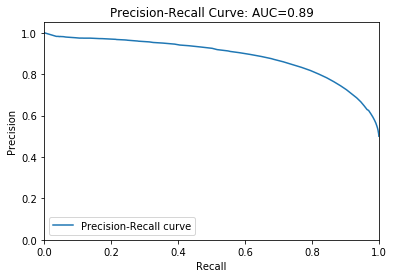

['joblib_data/clf_random_forest_pystemmer_svd.joblib']

In [111]:
score_model(clf, X_train_tfidf_pystemmer_svd, X_test_tfidf_pystemmer_svd, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_pystemmer_svd.joblib")

## LinearSVC

In [112]:
from sklearn import svm

### No_stemmer

In [113]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

Wall time: 5min 29s


In [114]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

Wall time: 125 ms


In [115]:
score_model(clf, X_train_tfidf_nostemmer_svd, X_test_tfidf_nostemmer_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_linearsvc_nostemmer_svd.joblib")

Train Accuracy       0.81417
Test Accuracy        0.81442
Test Precision       0.82533
Test Recall          0.79786
F1                   0.81136
F2                   0.80321
             precision    recall  f1-score   support

      False    0.80419   0.83099   0.81737    164923
       True    0.82533   0.79786   0.81136    165077

avg / total    0.81477   0.81442   0.81437    330000



['joblib_data/clf_linearsvc_nostemmer_svd.joblib']

### Porter

In [116]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_Porter_svd, y_train)

Wall time: 4min 17s


In [117]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

Wall time: 125 ms


In [118]:
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_linearsvc_porter_svd.joblib")

Train Accuracy       0.81397
Test Accuracy        0.81379
Test Precision       0.82199
Test Recall          0.80129
F1                   0.81151
F2                   0.80535
             precision    recall  f1-score   support

      False    0.80600   0.82631   0.81603    164923
       True    0.82199   0.80129   0.81151    165077

avg / total    0.81400   0.81379   0.81377    330000



['joblib_data/clf_linearsvc_porter_svd.joblib']

### Lancaster

In [119]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

Wall time: 4min 34s


In [120]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

Wall time: 125 ms


In [121]:
score_model(clf, X_train_tfidf_Lancaster_svd, X_test_tfidf_Lancaster_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_linearsvc_lancaster_svd.joblib")

Train Accuracy       0.81078
Test Accuracy        0.81085
Test Precision       0.81992
Test Recall          0.79688
F1                   0.80824
F2                   0.80139
             precision    recall  f1-score   support

      False    0.80226   0.82482   0.81338    164923
       True    0.81992   0.79688   0.80824    165077

avg / total    0.81109   0.81085   0.81081    330000



['joblib_data/clf_linearsvc_lancaster_svd.joblib']

### Pystemmer

In [122]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

Wall time: 3min 59s


In [123]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

Wall time: 125 ms


In [124]:
score_model(clf, X_train_tfidf_pystemmer_svd, X_test_tfidf_pystemmer_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_linearsvc_pystemmer_svd.joblib")

Train Accuracy       0.81059
Test Accuracy        0.81131
Test Precision       0.82105
Test Recall          0.79637
F1                   0.80852
F2                   0.80118
             precision    recall  f1-score   support

      False    0.80213   0.82626   0.81402    164923
       True    0.82105   0.79637   0.80852    165077

avg / total    0.81159   0.81131   0.81127    330000



['joblib_data/clf_linearsvc_pystemmer_svd.joblib']

## SVC

### No stemmer

In [125]:
clf = svm.SVC(random_state=42, max_iter=500)

In [ ]:
%%time
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

In [ ]:
score_model(clf, X_train_tfidf_nostemmer_svd, X_test_tfidf_nostemmer_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_svc_nostemmer_svd.joblib")

### Porter

In [ ]:
clf = svm.SVC(random_state=42, max_iter=500)

In [ ]:
%%time
clf.fit(X_train_tfidf_Porter_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

In [ ]:
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_svc_porter_svd.joblib")

### Lancaster

In [ ]:
clf = svm.SVC(random_state=42, max_iter=500)

In [ ]:
%%time
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

In [ ]:
score_model(clf, X_train_tfidf_Lancaster_svd, X_test_tfidf_Lancaster_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_svc_lancaster_svd.joblib")

### Pystemmer

In [ ]:
clf = svm.SVC(random_state=42, max_iter=500)

In [ ]:
%%time
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

In [ ]:
score_model(clf, X_train_tfidf_pystemmer_svd, X_test_tfidf_pystemmer_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_svc_pystemmer_svd.joblib")

## Adaboost
### 10 estimators

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
%%time
clf = AdaBoostClassifier(n_estimators=10, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)

### 15 estimators

In [ ]:
%%time
clf = AdaBoostClassifier(n_estimators=15, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)

Increasing the number of estimators lead to an improvement in performances
## 20 estimators

In [ ]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)

Performances are a bit better. Apparently the best configuration is the "20 estimators" one. Let's now build predictive models for all 4 representations.

## 20 Estimators
### No stemming

In [ ]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

In [ ]:
score_model(clf, X_train_tfidf_nostemmer_svd, X_test_tfidf_nostemmer_svd, y_train, y_test)
dump(clf, "joblib_data/clf_adaboost_nostemmer_svd.joblib")

### Porter

In [ ]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

In [ ]:
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)
dump(clf, "joblib_data/clf_adaboost_porter_svd.joblib")

### Lancaster

In [ ]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

In [ ]:
score_model(clf, X_train_tfidf_Lancaster_svd, X_test_tfidf_Lancaster_svd, y_train, y_test)
dump(clf, "joblib_data/clf_adaboost_Lancaster_svd.joblib")

### Pystemmer

In [ ]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

In [ ]:
score_model(clf, X_train_tfidf_pystemmer_svd, X_test_tfidf_pystemmer_svd, y_train, y_test)
dump(clf, "joblib_data/clf_adaboost_pystemmer_svd.joblib")

The best vectorizer was the 'No stemmer' one: because of GH constraints I will zip it.

In [ ]:
import gzip
import shutil
with open("joblib_data/tfidf_vect_nostemmer.joblib", 'rb') as f_in, gzip.open("joblib_data/tfidf_vect_nostemmer.joblib.zip", 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)